In [120]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy as ap
import plot_utils as pu
import utils as ut
import copy

G = ap.constants.G.value
h = ap.constants.h.value
k_B = ap.constants.k_B.value
m_p = ap.constants.m_p.value
m_e = ap.constants.m_e.value

## Mass and Radius of Non-Relativistic White Dwarf 

In [134]:
enes = [3/2]
n = enes[0]
M = len(enes)
xi_range = (0.01, 4)
dt = 1e-4

xis, th_arr, dthdxi_arr = ut.solve_polytropes(enes, dt=dt, xi_range=xi_range)
theta = th_arr[:, 0]
dthdxi = dthdxi_arr[:, 0]
coefs, n_coef = ut.get_coefs(enes, xis, th_arr, dthdxi_arr)
coefs = coefs['1.5']

In [175]:
R_earth = 6.371e6
R_sun = 6.957e8
M_sun = 1.989e30

mu_e = 2
K_1_prime = (3/np.pi)**(2/3) * (h**2 / (20 * m_e * m_p**(5/3))) 
K_1 = K_1_prime / (mu_e)**(5/3)
print(K_1)

R = coefs['R_n']
Lambda = coefs['G_n']
M_n = coefs['M_n']


M_w = 0.5405 * M_sun

pc_w_1 = np.sqrt(4*np.pi) * M_w / M_n 
pc_w_2 = (G/((n+1)*K_1))**(3/2)
pc_w = (pc_w_1 * pc_w_2) ** (2*n/(3-n))
pc_w = 4*np.pi * (2*G / (5*K_1))**3 * (M_w / M_n)**2 # it's an equivalent expression


rho_cs = [5e8, 1e9, 5e9, pc_w]

R = coefs['R_n']
Lambda = coefs['G_n']



masses, radiuses = np.zeros(len(rho_cs)), np.zeros(len(rho_cs))
info = {}

for i, rho_c in enumerate(rho_cs):

    info[i] = {}

    rho = rho_c * theta**n
    info[i]['logrho'] = np.log10(rho)
    # get index of first nan
    idx = np.where(np.isnan(rho))[0][0]
    info[i]['logrho'][idx] = 1


    alpha_num = (n+1) * K_1
    alpha_den = 4 * np.pi * G * rho_c ** ((n-1)/n)
    alpha_squared = alpha_num / alpha_den
    alpha = np.sqrt(alpha_squared)


    factor_mass = - 4 * np.pi * (alpha ** 3) * rho_c
    m_arr = factor_mass * xis**2 * dthdxi
    info[i]['Ms'] = m_arr / M_sun




    r_arr = xis * alpha
    info[i]['Rs'] = r_arr / R_sun


    mass = factor_mass * R**2 * (-1*Lambda)
    radius = alpha * R

    info[i]['Mass'] = mass/M_sun
    info[i]['Radius'] = radius/R_sun

    print(f'rho_c = {rho_c:.2e} kg/m^3')
    print(f'M = {mass:.2e} kg, {mass/M_sun:.3e} M_sun')
    print(f'R = {radius:.2e} m, {radius/R_sun:.2e} R_sun, {radius/R_earth:.2e} R_earth')
    print('\n')

3123160.8686828413
rho_c = 5.00e+08 kg/m^3
M = 6.85e+29 kg, 3.444e-01 M_sun
R = 1.25e+07 m, 1.80e-02 R_sun, 1.96e+00 R_earth


rho_c = 1.00e+09 kg/m^3
M = 9.69e+29 kg, 4.871e-01 M_sun
R = 1.11e+07 m, 1.60e-02 R_sun, 1.75e+00 R_earth


rho_c = 5.00e+09 kg/m^3
M = 2.17e+30 kg, 1.089e+00 M_sun
R = 8.51e+06 m, 1.22e-02 R_sun, 1.34e+00 R_earth


rho_c = 1.23e+09 kg/m^3
M = 1.08e+30 kg, 5.405e-01 M_sun
R = 1.08e+07 m, 1.55e-02 R_sun, 1.69e+00 R_earth




C:\Users\Pere\AppData\Local\Temp\ipykernel_27860\3776029002.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)


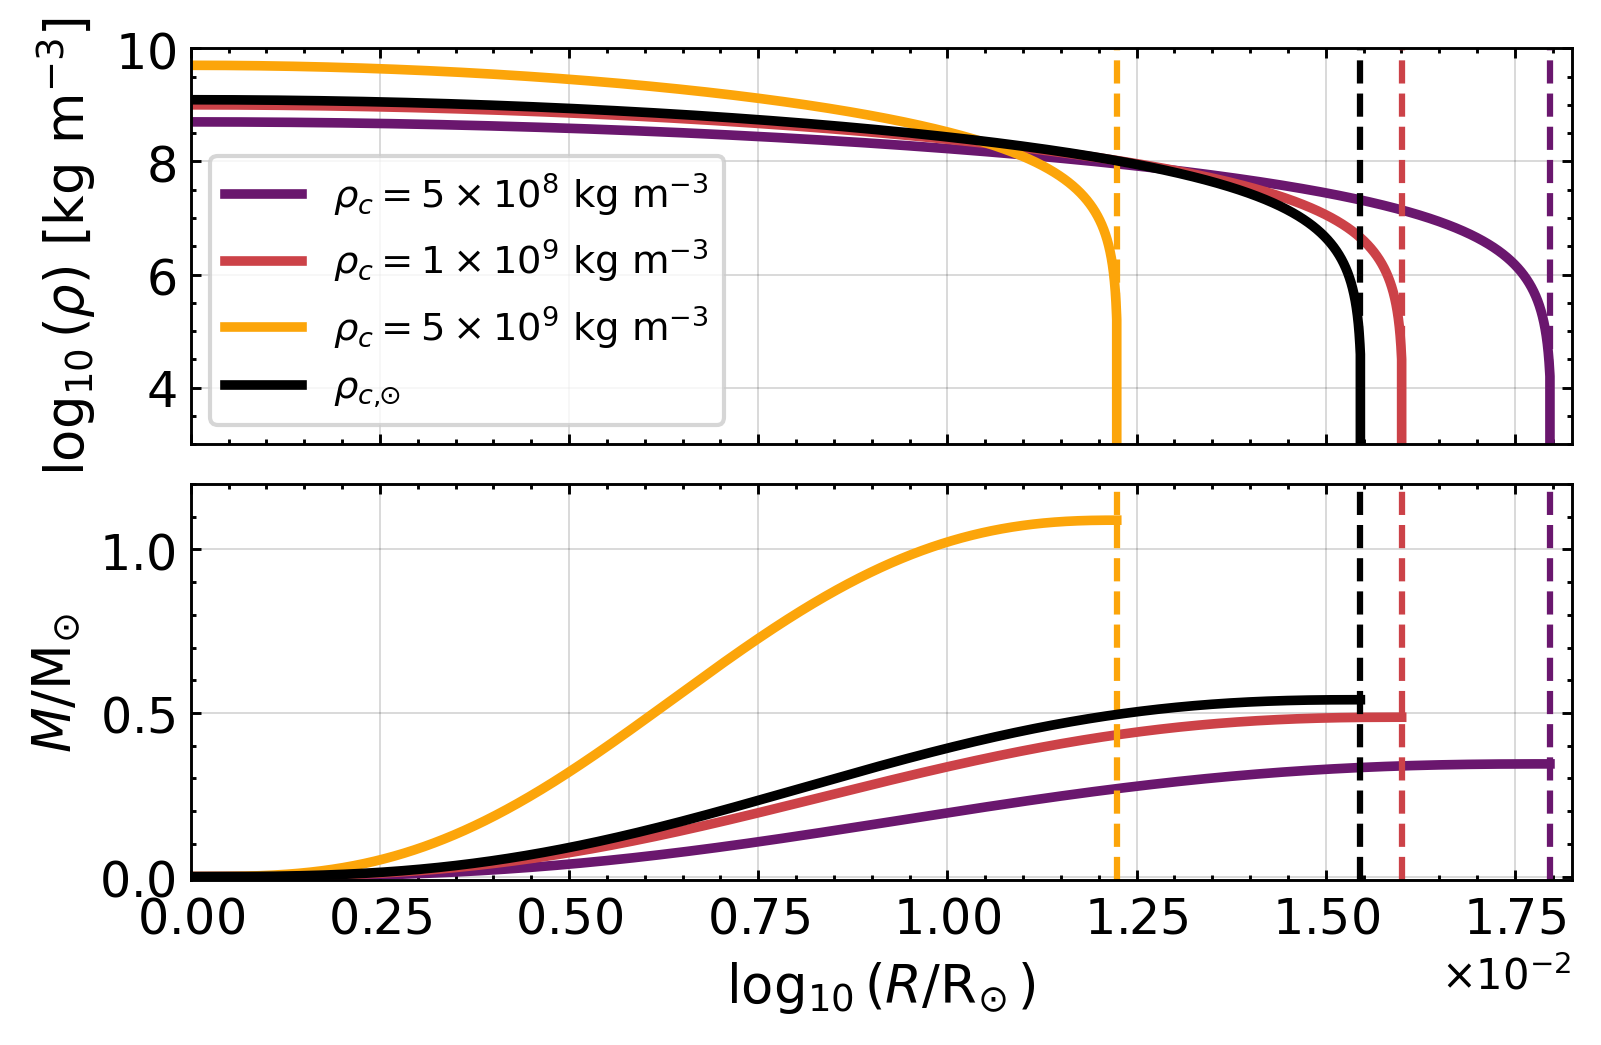

In [176]:
size, rat = 1080, 1.65
fig_w, fig_h = size*rat, size
subplots = (2, 1)
lw, ts, pad = 0.1, 2.55, 0.75
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h,
                                        ratio=None, theme=None,
                                        subplots=subplots,
                                        tick_direction='in',
                                        top_bool=True,
                                        pad=pad,
                                        layout=None, hspace=0.1, wspace=0.075,
                                        # hr = [4,1],
                                        ts=ts,
                                        minor=True)
ax = axs[0][0]
ax1 = axs[1][0]

lws = 0.5
cmap_name = 'inferno'
cmap = mpl.cm.get_cmap(cmap_name)
colors = [cmap(i) for i in np.linspace(0.3, 0.8, 3)]
colors = colors + ['k']
for i, kei in enumerate(info):
    if i != len(info)-1:
        lab = ut.format_scientific(rho_cs[kei], prec=0)
        label = rf'$\rho_c=${lab} kg m$^{{-3}}$'
    else:
        label = r'$\rho_{c,\!\!\!\odot}$'

    ax.plot(info[kei]['Rs'], info[kei]['logrho'], 
            label=label,
            lw=lws*fs,
            c=colors[i])
    ax1.plot(info[kei]['Rs'], info[kei]['Ms'], 
            #label=label,
            lw=lws*fs,
             c=colors[i])
    
    idx = np.where(np.isnan(rho))[0][0]
    rad = info[i]['Radius'] 
    rho_last = info[kei]['logrho'][idx-1]
    mass_last = info[kei]['Ms'][idx-1]
    for ax_ in [ax, ax1]:
        ax_.plot([rad, rad], [-100,100], lw=lws*0.65*fs, c=colors[i], ls='--')
        
    #ax.text(rad, rho_last, f'{rho_last:.2f}', fontsize=fs*0.75, ha='center', va='bottom')

# ax.set_xlabel(r'$\log_{10}(R/R_\odot)$ \ [m]')
lbs = 2.75

ax.set_ylabel(r'$\log_{10}(\rho) \ [\text{kg} \ \text{m}^{-3}]$', fontsize=fs*lbs)

ax1.set_xlabel(r'$\log_{10}(R/\text{R}_{\!\odot})$', fontsize=fs*lbs)
ax1.set_ylabel(r'$M/\text{M}_{\!\odot}$', fontsize=fs*lbs)

ax.legend(loc='lower left', fontsize=fs*2, frameon=True)

# remove ax xticks
ax.set_xticklabels([])

plt.rcParams['axes.formatter.use_mathtext'] = True

# ax1 xticks in scientific notation
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax.set_ylim(3,10)
ax1.set_ylim(-0.01,1.2)

for ax_ in [ax, ax1]:
    ax_.set_xlim(0, 0.01825)


savefold = '../figures/'
if not os.path.exists(savefold):
    os.makedirs(savefold)
filename = f'fig_WD.png'
savepath = os.path.join(savefold, filename)

# save figure
fig.savefig(savepath, dpi=300, bbox_inches='tight')


In [167]:
info[kei]['logrho']

array([9.09036744, 9.09036744, 9.09036743, ...,        nan,        nan,
       1.        ])

In [168]:
info[kei]['Rs']

array([4.23619696e-05, 4.27856000e-05, 4.32092303e-05, ...,
       1.69439406e-02, 1.69443642e-02, 1.69447879e-02])